In [18]:
import string

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import ScalarFormatter

In [2]:
sns.set_theme(color_codes=True, style='ticks', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[2:5] + PALETTE[6:], n_colors=9)

NROWS, NCOLS = 2, 3
SAMPLE_SIZES = [256, 512, 1024, 2048, 4096]
DIM_SIZES = [2**i for i in range(2, 13)]
DATA_PATH = "results"
FIG_PATH = "figs"

SIMULATIONS = {
    "linear" : "Linear",
    "nonlinear" : "Nonlinear",
    "independent" : "Independent",
}

S98_KWARGS = {
    "SVMrbf" : {"color" : "#ff7f00", "label" : "SVM"},
    "LRliblinear" : {"color" : "#984ea3", "label" : "LR"},
    "KNN" : {"color" : "#4daf4a", "label" : "KNN"},
    "RF" : {"color" : "#377eb8", "label" : "RF"},
    "might" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
    "Truth" : {
        "linear" : 0.14,
        "nonlinear" : 0.26,
        "independent": 0.02
    }
}

STAT_KWARGS = {
    "S98" : S98_KWARGS,
}

In [47]:
def plot_stats(stat="S98", fig_name="figure-2"):
    fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(24, 14))

    stat_kwargs = STAT_KWARGS[stat]
    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            sim = list(SIMULATIONS)[c]
            col.axhline(y=stat_kwargs["Truth"][sim], linestyle=":", color="#000000", label="Truth")

            for test, plot_kwargs in stat_kwargs.items():
                if test != "Truth":
                    if r == 0:
                        xs = SAMPLE_SIZES
                        try:
                            ys = np.genfromtxt(f"{DATA_PATH}/{sim}-{test}-{stat}-vs-n.csv", delimiter=',')
                        except FileNotFoundError:
                            continue
                    elif r == 1:
                        xs = DIM_SIZES
                        try:
                            ys = np.genfromtxt(f"{DATA_PATH}/{sim}-{test}-{stat}-vs-d.csv", delimiter=',')
                        except FileNotFoundError:
                            continue
                    medians = np.quantile(ys, 0.5, axis=1)
                    lower_quartile = np.quantile(ys, 0.25, axis=1)
                    upper_quartile = np.quantile(ys, 0.75, axis=1)
                    col.plot(xs, medians, **plot_kwargs)
                    col.fill_between(xs, lower_quartile, upper_quartile, alpha=0.2, color=plot_kwargs["color"])

            col.set(
                title=SIMULATIONS[sim] if r == 0 else "",
                xscale="log",
                # yscale="log",
                xlabel=(
                    "Sample Size" if r == 0
                    else "# of Variables" if r == 1
                    else ""
                ),
                ylabel=(
                    f"{stat} for 4096 Variables" if r == 0 and c == 0
                    else f"{stat} for 4096 Samples" if r == 1 and c == 0
                    else ""
                ),
                yticks=[0, stat_kwargs["Truth"][sim]],
                ylim=[0, stat_kwargs["Truth"][sim] + 0.4 * stat_kwargs["Truth"][sim]],
                xticks=(
                    [200, 2000, 4000] if r == 0
                    else [40, 400, 4000] if r == 1
                    else ""
                )
            )
            col.get_xaxis().set_major_formatter(ScalarFormatter())
            col.get_yaxis().set_major_formatter(ScalarFormatter())
            col.set_title(string.ascii_uppercase[r * NROWS + c], loc="left", weight='bold')
            sns.despine(right=True)
            plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=1.0)
            
    leg = row[0].legend(
        bbox_to_anchor=(0.5, -0.03),
        bbox_transform=plt.gcf().transFigure,
        ncol=len(S98_KWARGS),
        loc="upper center",
        reverse=True
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)

    plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches='tight')

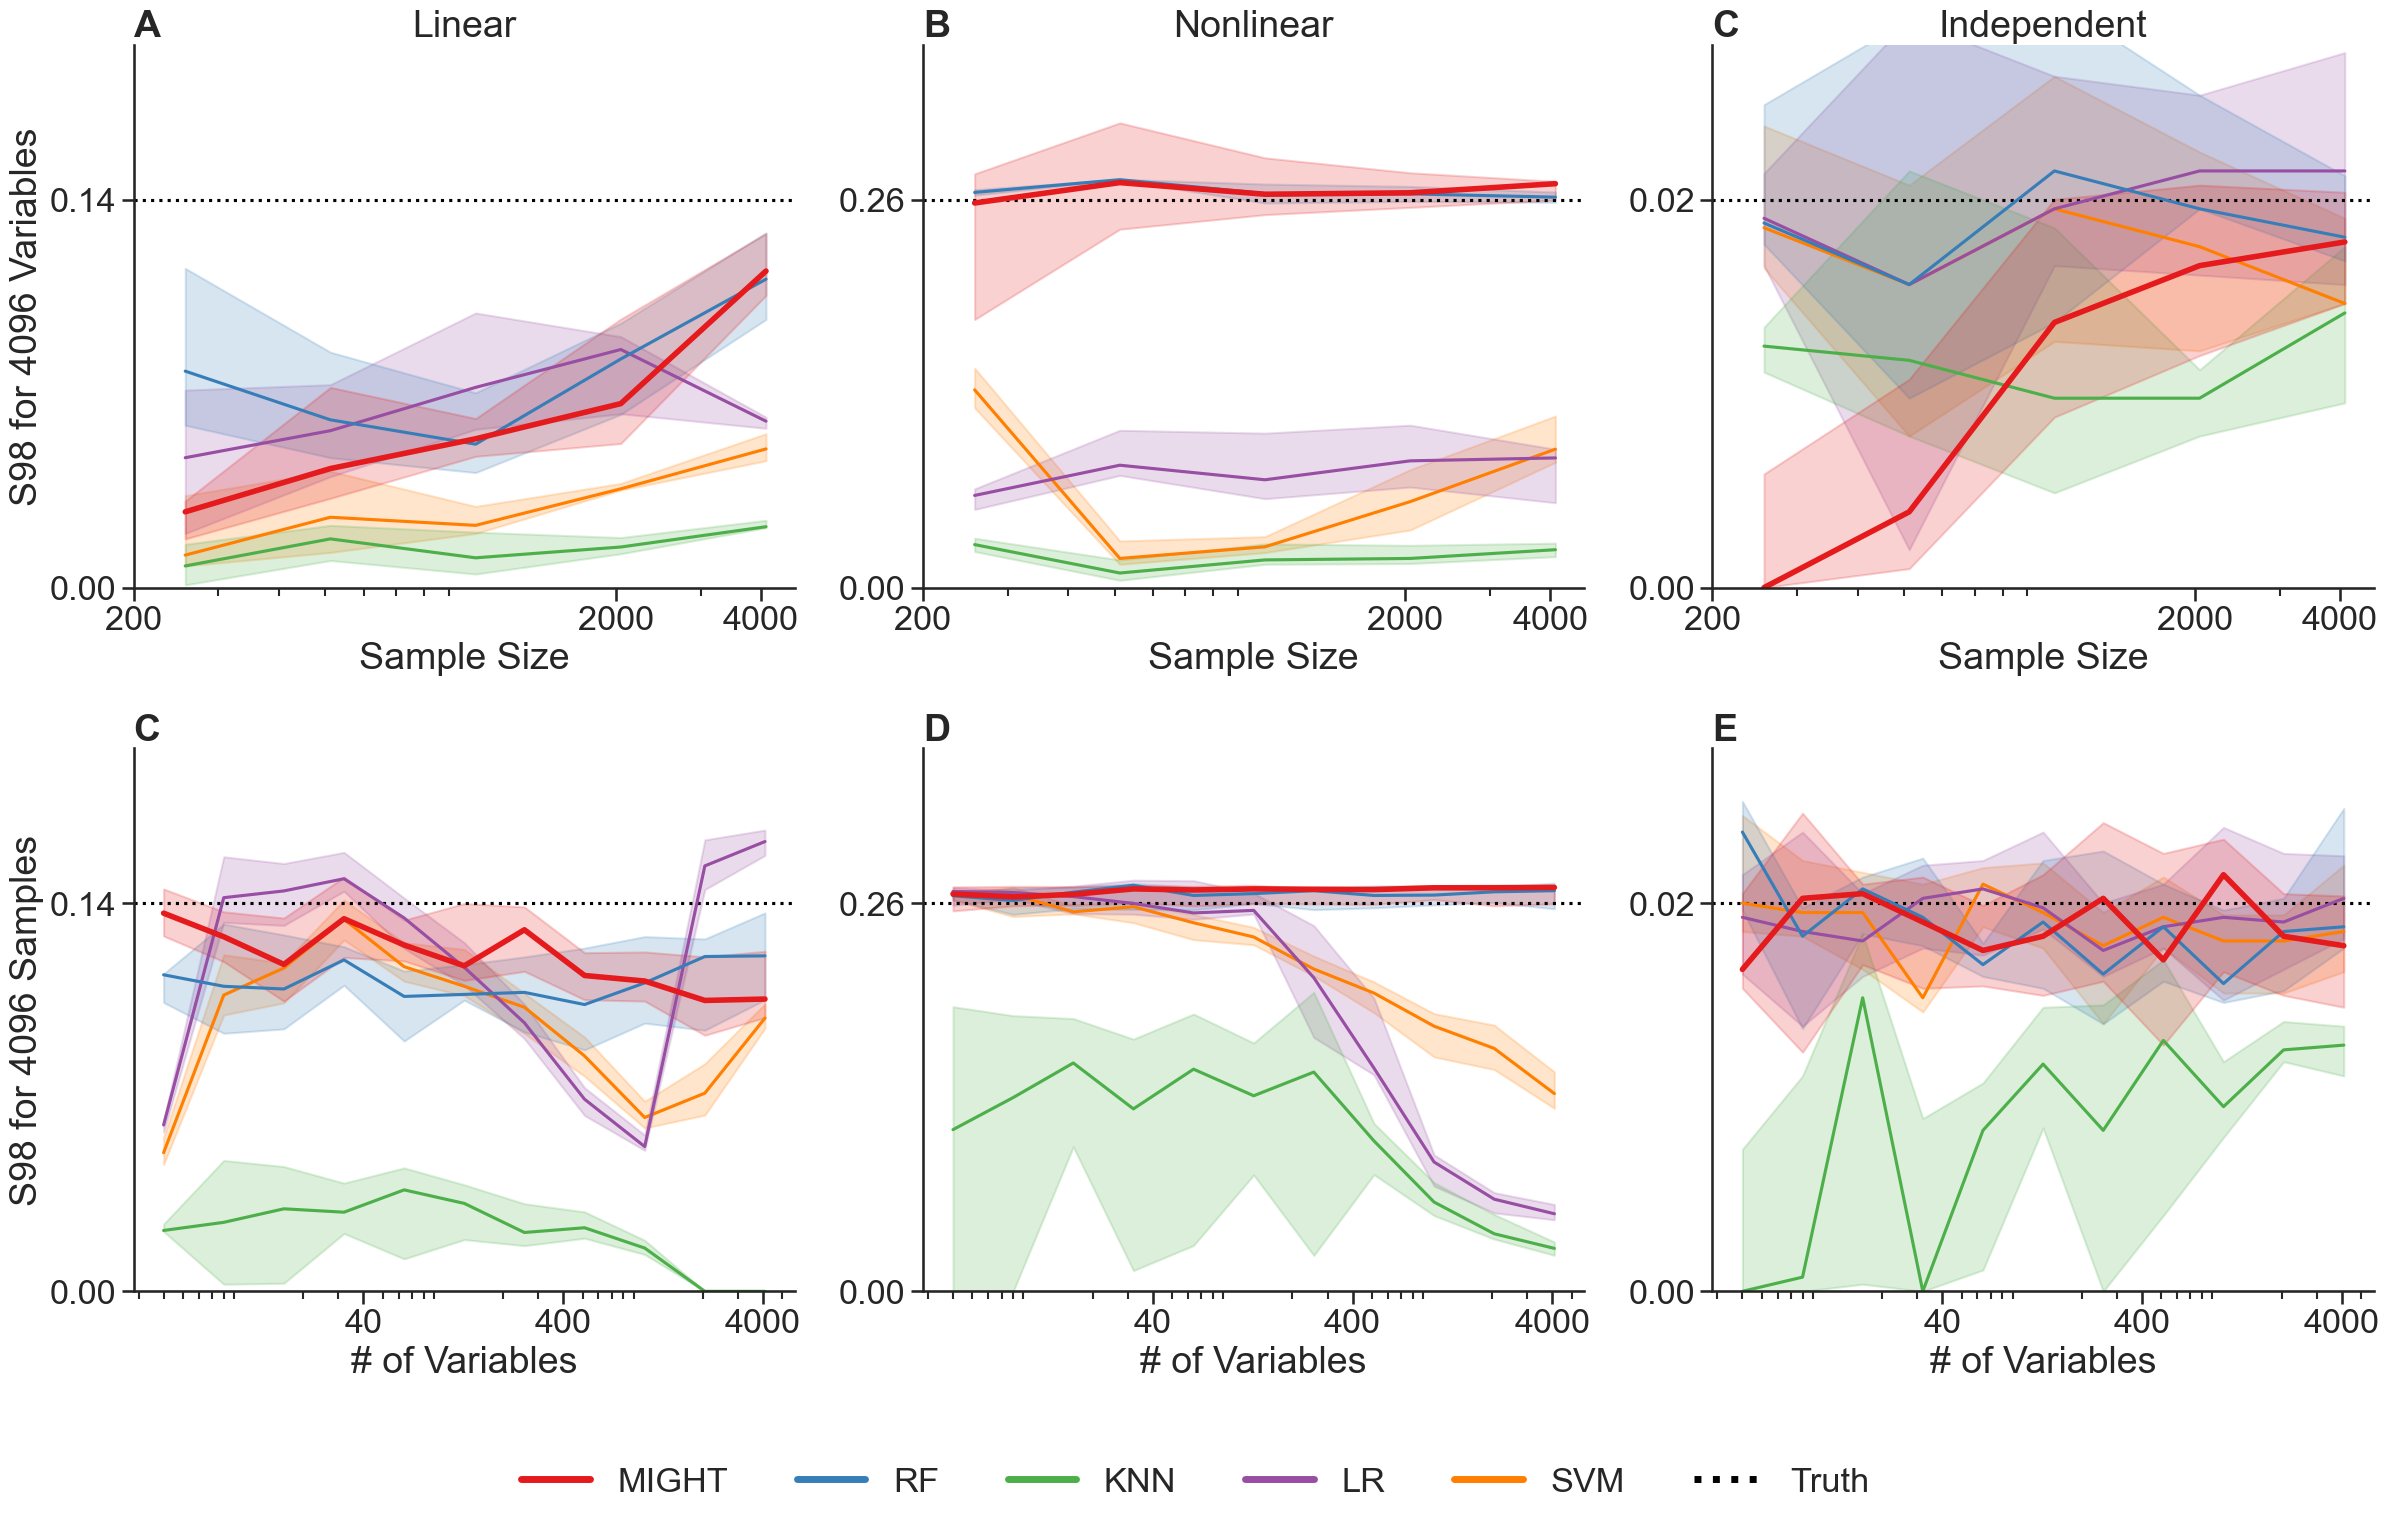

In [48]:
plot_stats(stat="S98", fig_name="figure-2")

In [5]:
# # Data refactoring for non-MIGHT curves

# import pandas as pd

# def refactor_data(data, alg="SVMrbf", stat="S@98", sim="linear", type="n"):
#     df = pd.read_csv(data)
#     grouped = df.groupby(df.sim)
#     svm = grouped.get_group(alg)
#     if type == "n":
#         refactored_data = svm[svm["dim"] == 4096][stat].to_numpy().reshape(len(SAMPLE_SIZES), -1)
#     elif type == "d":
#         refactored_data = svm[svm["samp"] == 4096][stat].to_numpy().reshape(len(DIM_SIZES), -1)
#     if stat == "S@98":
#         stat = "S98"
#     np.savetxt(f"/Users/spanda/workspace/might/results/{sim}-{alg}-{stat}-vs-{type}.csv", refactored_data, delimiter=",")


# FILES = {
#     # "linear" : "trunk",
#     # "nonlinear" : "trunk_mix",
#     "independent" : "trunk_overlap"
# }


# for sim, file in FILES.items():
#     for type in ["n", "d"]:
#         for alg in ["SVMrbf", "LRliblinear", "KNN", "RF"]:
#             refactor_data(data=f"/Users/spanda/Documents/S98_{file}.csv", alg=alg, stat="S@98", type=type, sim=sim)